## HELOC Bonus Assignment
Author: Andrew Knight

In [1]:
# Setup and Imports
import pandas as pd
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import statsmodels as sm
import statsmodels.formula.api as smf  # R-like model specification
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn import linear_model, metrics
#pd.show_versions()

In [2]:
#Read in the auto ins dataset
train = pd.read_sas('heloc.sas7bdat')
#test = pd.read_csv('heloc_test.sas7bdat')

print(train.shape)
train = train.fillna(0)
train.head()

(4730, 14)


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,2.0,1.0,1300.0,70053.0,68400.0,b'HomeImp',b'Other',7.0,0.0,2.0,121.833333,0.0,14.0,0.000000
1,3.0,1.0,1500.0,13500.0,16700.0,b'HomeImp',b'Other',4.0,0.0,0.0,149.466667,1.0,10.0,0.000000
2,4.0,1.0,1500.0,0.0,0.0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,5.0,0.0,1700.0,97800.0,112000.0,b'HomeImp',b'Office',3.0,0.0,0.0,93.333333,0.0,14.0,0.000000
4,6.0,1.0,1700.0,30548.0,40320.0,b'HomeImp',b'Other',9.0,0.0,0.0,101.466002,1.0,8.0,37.113614


## Create a test set
Because I could not get the heloc_test.sas7bdat test file to import due to a encoding error, I decided to take the training data and randomly sample from it to set aside test data before building the model.

In [3]:
# Create a test set from the original training sample before doing any analysis, use 25% of the original training data
seed = 123 # seed used for random sampling, for reproducibility
test = train.sample(frac = 0.25, replace = False, random_state = seed)
print(test.shape)
test.head()

(1182, 14)


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3216,4052.0,1.0,21200.0,69212.0,106273.0,b'DebtCon',b'ProfExe',12.0,0.0,1.0,97.231123,0.0,22.0,18.114896
4058,5116.0,0.0,27400.0,51298.0,90010.0,b'DebtCon',b'Other',6.0,1.0,0.0,146.656220,3.0,29.0,42.159937
2589,3254.0,0.0,17400.0,62824.0,82243.0,b'DebtCon',b'Other',5.0,0.0,0.0,109.482749,0.0,7.0,34.818445
146,188.0,1.0,5000.0,61999.0,75021.3,b'HomeImp',b'Other',5.0,0.0,0.0,97.100000,0.0,23.0,0.000000
3002,3783.0,0.0,20000.0,13316.0,50150.0,b'DebtCon',b'Other',26.0,0.0,2.0,214.033333,0.0,25.0,0.000000


In [4]:
# Now, because we had to take a a sample from the training set, we must remove those items from train before we proceed (these msut be set aside as test only)
train = train[~train.isin(test)].dropna()
print(train.shape)
train.head()

(3548, 14)


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,2.0,1.0,1300.0,70053.0,68400.0,b'HomeImp',b'Other',7.0,0.0,2.0,121.833333,0.0,14.0,0.0
1,3.0,1.0,1500.0,13500.0,16700.0,b'HomeImp',b'Other',4.0,0.0,0.0,149.466667,1.0,10.0,0.0
2,4.0,1.0,1500.0,0.0,0.0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,5.0,0.0,1700.0,97800.0,112000.0,b'HomeImp',b'Office',3.0,0.0,0.0,93.333333,0.0,14.0,0.0
5,7.0,1.0,1800.0,48649.0,57037.0,b'HomeImp',b'Other',5.0,3.0,2.0,77.100000,1.0,17.0,0.0


In [5]:
#should get remaining training data set with 3548 records, which combined gives the original number of 4730
train.shape[0] + test.shape[0]

4730

In [6]:
print(train.info())
train.dropna()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 4729
Data columns (total 14 columns):
INDEX          3548 non-null float64
TARGET_FLAG    3548 non-null float64
LOAN           3548 non-null float64
MORTDUE        3548 non-null float64
VALUE          3548 non-null float64
REASON         3548 non-null object
JOB            3548 non-null object
YOJ            3548 non-null float64
DEROG          3548 non-null float64
DELINQ         3548 non-null float64
CLAGE          3548 non-null float64
NINQ           3548 non-null float64
CLNO           3548 non-null float64
DEBTINC        3548 non-null float64
dtypes: float64(12), object(2)
memory usage: 415.8+ KB
None


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,2.0,1.0,1300.0,70053.0,68400.0,b'HomeImp',b'Other',7.0,0.0,2.0,121.833333,0.0,14.0,0.000000
1,3.0,1.0,1500.0,13500.0,16700.0,b'HomeImp',b'Other',4.0,0.0,0.0,149.466667,1.0,10.0,0.000000
2,4.0,1.0,1500.0,0.0,0.0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,5.0,0.0,1700.0,97800.0,112000.0,b'HomeImp',b'Office',3.0,0.0,0.0,93.333333,0.0,14.0,0.000000
5,7.0,1.0,1800.0,48649.0,57037.0,b'HomeImp',b'Other',5.0,3.0,2.0,77.100000,1.0,17.0,0.000000
6,8.0,1.0,1800.0,28502.0,43034.0,b'HomeImp',b'Other',11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
7,11.0,1.0,2000.0,22608.0,0.0,0,0,18.0,0.0,0.0,0.000000,0.0,0.0,0.000000
8,12.0,1.0,2000.0,20627.0,29800.0,b'HomeImp',b'Office',11.0,0.0,1.0,122.533333,1.0,9.0,0.000000
9,13.0,1.0,2000.0,45000.0,55000.0,b'HomeImp',b'Other',3.0,0.0,0.0,86.066667,2.0,25.0,0.000000
10,15.0,1.0,2100.0,71000.0,83850.0,b'HomeImp',b'Other',8.0,0.0,1.0,123.000000,0.0,16.0,0.000000


### Part 1 - EDA

#### TRAIN DATA SET

In [7]:
# Now we have the training and test sets, let's take a look at the data
# ------------- TRAINING -----------------
print(train.info())
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 4729
Data columns (total 14 columns):
INDEX          3548 non-null float64
TARGET_FLAG    3548 non-null float64
LOAN           3548 non-null float64
MORTDUE        3548 non-null float64
VALUE          3548 non-null float64
REASON         3548 non-null object
JOB            3548 non-null object
YOJ            3548 non-null float64
DEROG          3548 non-null float64
DELINQ         3548 non-null float64
CLAGE          3548 non-null float64
NINQ           3548 non-null float64
CLNO           3548 non-null float64
DEBTINC        3548 non-null float64
dtypes: float64(12), object(2)
memory usage: 415.8+ KB
None


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000
mean,2969.831172,0.201522,18486.076663,67664.229448,100486.432734,8.190967,0.215614,0.397971,169.971027,1.087373,20.335118,26.544423
std,1727.911963,0.401194,11047.074251,47085.600414,59036.699491,7.673797,0.756525,1.072777,93.006366,1.689026,10.794941,15.711889
min,2.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1475.750000,0.000000,11000.000000,39000.000000,64865.500000,2.000000,0.000000,0.000000,107.246414,0.000000,14.000000,20.286471
50%,2968.500000,0.000000,16300.000000,62331.500000,89020.500000,6.000000,0.000000,0.000000,167.366667,0.000000,20.000000,31.711329
75%,4482.250000,0.000000,23400.000000,89206.500000,120888.500000,12.000000,0.000000,0.000000,225.295830,2.000000,26.000000,37.978157
max,5960.000000,1.000000,89900.000000,399550.000000,854114.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [8]:
#All but two variables given are numerics, let's take a look at JOB and REASON.
print(train['JOB'].value_counts())
print(train['REASON'].value_counts())
# We might want to convert these to category codes below.

b'Other'      1405
b'ProfExe'     759
b'Office'      563
b'Mgr'         468
0              170
b'Self'        123
b'Sales'        60
Name: JOB, dtype: int64
b'DebtCon'    2325
b'HomeImp'    1070
0              153
Name: REASON, dtype: int64


In [9]:
# First, looks like there are some records with non-zero mortgage due and zero home value, let's indicate these with a new variable
print(len(train[train['MORTDUE'] < 1]))
print(len(train[train['VALUE'] < 1]))
train['ZERO_VAL'] = np.where(np.logical_and(train['MORTDUE'] > 0, train['VALUE'] == 0), 1, 0)
print(len(train[train['ZERO_VAL'] > 0]))
train.head(10)

312
62
48


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,ZERO_VAL
0,2.0,1.0,1300.0,70053.0,68400.0,b'HomeImp',b'Other',7.0,0.0,2.0,121.833333,0.0,14.0,0.000000,0
1,3.0,1.0,1500.0,13500.0,16700.0,b'HomeImp',b'Other',4.0,0.0,0.0,149.466667,1.0,10.0,0.000000,0
2,4.0,1.0,1500.0,0.0,0.0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0
3,5.0,0.0,1700.0,97800.0,112000.0,b'HomeImp',b'Office',3.0,0.0,0.0,93.333333,0.0,14.0,0.000000,0
5,7.0,1.0,1800.0,48649.0,57037.0,b'HomeImp',b'Other',5.0,3.0,2.0,77.100000,1.0,17.0,0.000000,0
6,8.0,1.0,1800.0,28502.0,43034.0,b'HomeImp',b'Other',11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,0
7,11.0,1.0,2000.0,22608.0,0.0,0,0,18.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1
8,12.0,1.0,2000.0,20627.0,29800.0,b'HomeImp',b'Office',11.0,0.0,1.0,122.533333,1.0,9.0,0.000000,0
9,13.0,1.0,2000.0,45000.0,55000.0,b'HomeImp',b'Other',3.0,0.0,0.0,86.066667,2.0,25.0,0.000000,0
10,15.0,1.0,2100.0,71000.0,83850.0,b'HomeImp',b'Other',8.0,0.0,1.0,123.000000,0.0,16.0,0.000000,0


In the TRAINING set, we have 3548 loan values ranging from 1,300 USD to 89,900 USD. Some of these (48 to be exact) home equity line of credit loans show home value of zero. Unless we are considering personal loans, which are not part of the assignment, a non-zero MORTDUE with a home value of zero indicates possible bad data. These will likely need removed in the data cleaning section that follows.

INDEX              AxesSubplot(0.125,0.71587;0.168478x0.16413)
TARGET_FLAG     AxesSubplot(0.327174,0.71587;0.168478x0.16413)
LOAN            AxesSubplot(0.529348,0.71587;0.168478x0.16413)
MORTDUE         AxesSubplot(0.731522,0.71587;0.168478x0.16413)
VALUE             AxesSubplot(0.125,0.518913;0.168478x0.16413)
YOJ            AxesSubplot(0.327174,0.518913;0.168478x0.16413)
DEROG          AxesSubplot(0.529348,0.518913;0.168478x0.16413)
DELINQ         AxesSubplot(0.731522,0.518913;0.168478x0.16413)
CLAGE             AxesSubplot(0.125,0.321957;0.168478x0.16413)
NINQ           AxesSubplot(0.327174,0.321957;0.168478x0.16413)
CLNO           AxesSubplot(0.529348,0.321957;0.168478x0.16413)
DEBTINC        AxesSubplot(0.731522,0.321957;0.168478x0.16413)
ZERO_VAL             AxesSubplot(0.125,0.125;0.168478x0.16413)
dtype: object

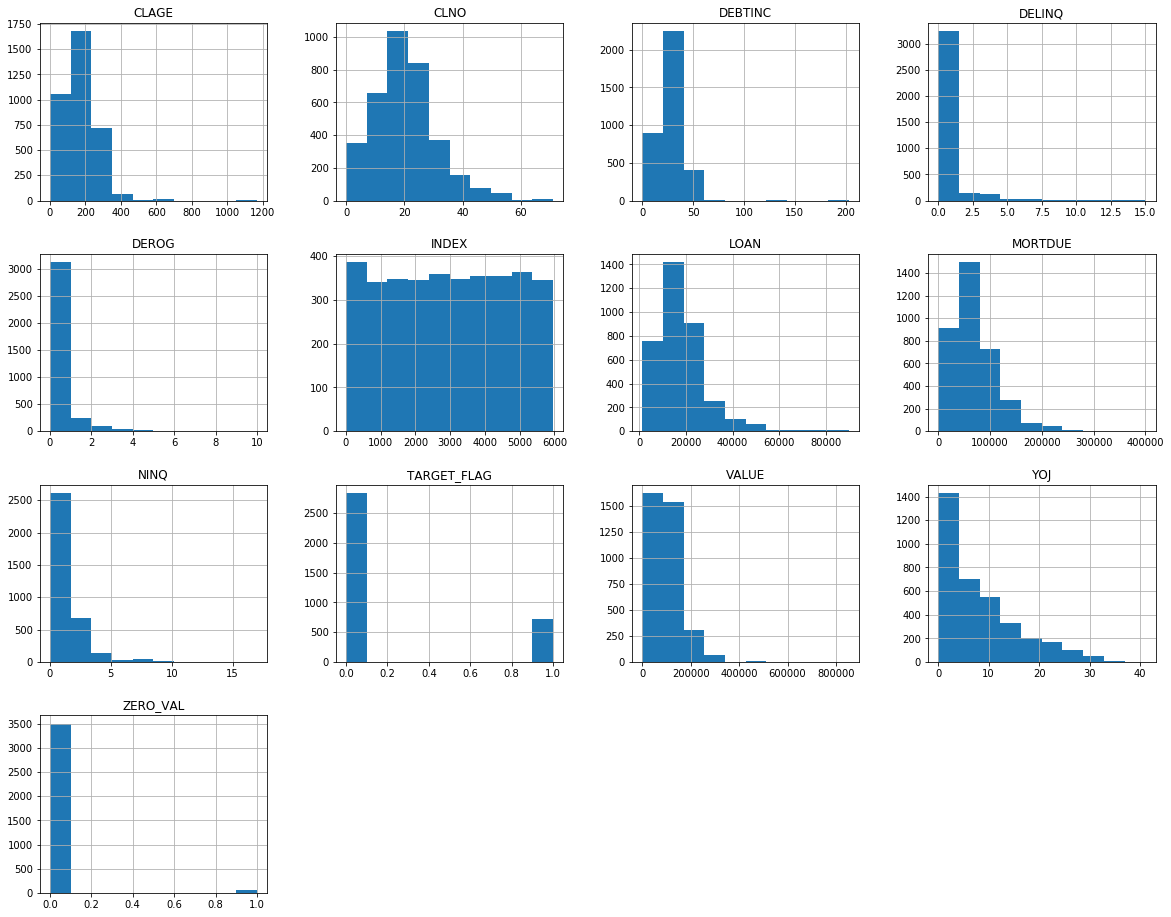

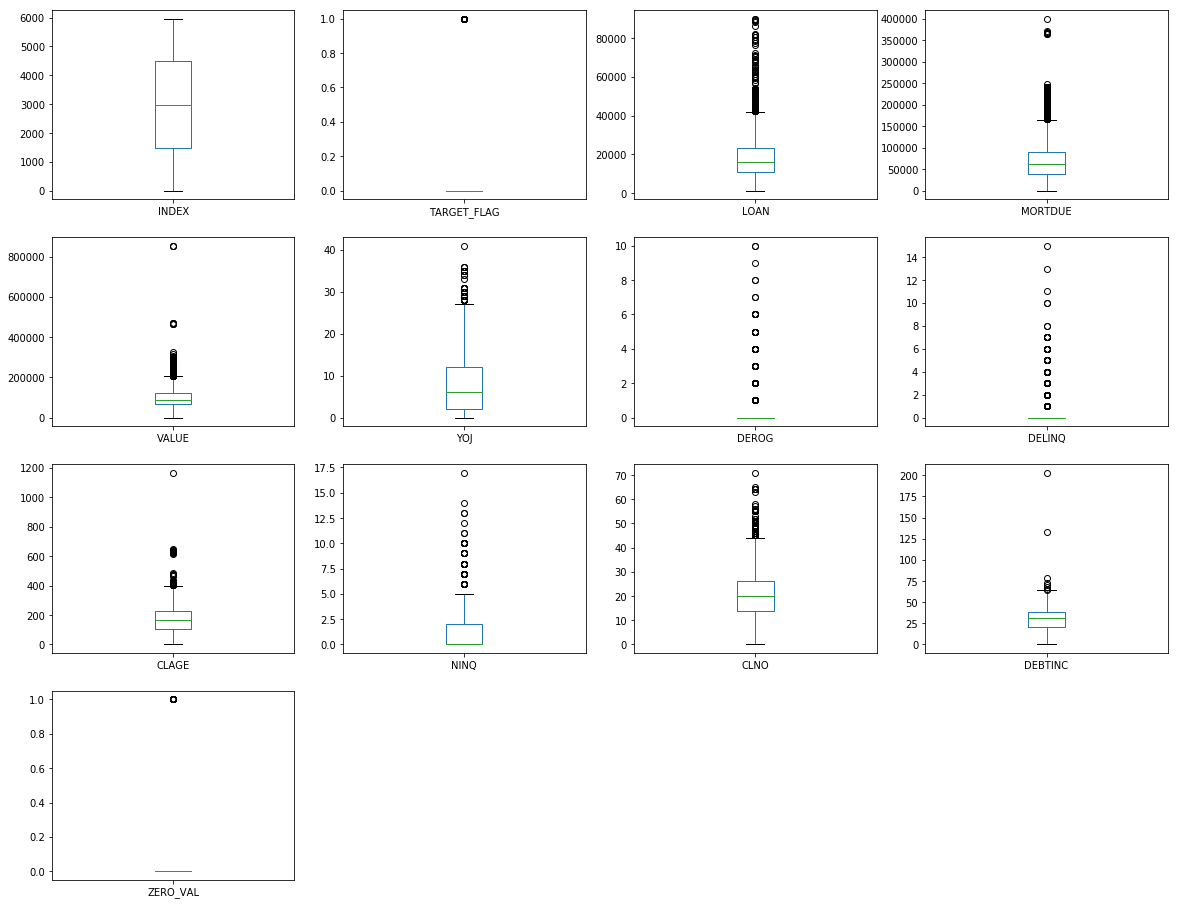

In [10]:
# Show training data plots
train.hist(figsize = (20, 16))
train.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))

#### TEST DATA SET

In [11]:
# We need to perform the same actions on the test set, let's take a look at the data
# ------------- TEST -----------------
print(test.info())
test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 3216 to 3894
Data columns (total 14 columns):
INDEX          1182 non-null float64
TARGET_FLAG    1182 non-null float64
LOAN           1182 non-null float64
MORTDUE        1182 non-null float64
VALUE          1182 non-null float64
REASON         1182 non-null object
JOB            1182 non-null object
YOJ            1182 non-null float64
DEROG          1182 non-null float64
DELINQ         1182 non-null float64
CLAGE          1182 non-null float64
NINQ           1182 non-null float64
CLNO           1182 non-null float64
DEBTINC        1182 non-null float64
dtypes: float64(12), object(2)
memory usage: 178.5+ KB
None


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000
mean,2993.631980,0.187817,18876.226734,67361.915093,99859.383359,8.244501,0.218274,0.449239,167.758958,1.044839,20.694585,26.903990
std,1707.235516,0.390731,11742.514937,45376.439275,58258.218340,7.656432,0.771906,1.090508,86.531519,1.651885,10.069981,15.605052
min,6.000000,0.000000,1700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1504.250000,0.000000,11100.000000,41217.250000,65996.250000,2.000000,0.000000,0.000000,108.002619,0.000000,14.000000,21.954846
50%,2965.500000,0.000000,16300.000000,61000.000000,87268.000000,6.000000,0.000000,0.000000,160.300000,0.000000,20.000000,32.176476
75%,4496.750000,0.000000,23500.000000,85852.500000,115671.750000,12.000000,0.000000,0.000000,223.058890,2.000000,26.000000,37.373858
max,5957.000000,1.000000,89000.000000,362000.000000,855909.000000,41.000000,9.000000,8.000000,629.095766,12.000000,58.000000,143.949605


In [12]:
#All but two variables given are numerics, let's take a look at JOB and REASON.
print(test['JOB'].value_counts())
print(test['REASON'].value_counts())
# We might want to convert these to category codes below.

b'Other'      466
b'ProfExe'    235
b'Office'     201
b'Mgr'        159
0              55
b'Self'        39
b'Sales'       27
Name: JOB, dtype: int64
b'DebtCon'    789
b'HomeImp'    347
0              46
Name: REASON, dtype: int64


In [13]:
# We have the same issue as the training set with some records with zero mortgage due and zero home value, let's find out how many also have zero value.
print(len(test[test['MORTDUE'] < 1]))
print(len(test[test['VALUE'] < 1]))
test['ZERO_VAL'] = np.where(np.logical_and(test['MORTDUE'] > 0, test['VALUE'] == 0), 1, 0)
print(len(test[test['ZERO_VAL'] > 0]))
test.head(10)

84
21
13


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,ZERO_VAL
3216,4052.0,1.0,21200.0,69212.0,106273.0,b'DebtCon',b'ProfExe',12.0,0.0,1.0,97.231123,0.0,22.0,18.114896,0
4058,5116.0,0.0,27400.0,51298.0,90010.0,b'DebtCon',b'Other',6.0,1.0,0.0,146.656220,3.0,29.0,42.159937,0
2589,3254.0,0.0,17400.0,62824.0,82243.0,b'DebtCon',b'Other',5.0,0.0,0.0,109.482749,0.0,7.0,34.818445,0
146,188.0,1.0,5000.0,61999.0,75021.3,b'HomeImp',b'Other',5.0,0.0,0.0,97.100000,0.0,23.0,0.000000,0
3002,3783.0,0.0,20000.0,13316.0,50150.0,b'DebtCon',b'Other',26.0,0.0,2.0,214.033333,0.0,25.0,0.000000,0
3460,4371.0,0.0,22700.0,46929.0,71169.0,b'DebtCon',b'Other',6.0,0.0,0.0,57.880816,2.0,19.0,35.552088,0
4441,5598.0,0.0,37200.0,205922.0,267238.0,b'DebtCon',b'ProfExe',2.0,1.0,0.0,238.211480,0.0,32.0,31.622844,0
2775,3491.0,0.0,18400.0,94952.0,129177.0,b'DebtCon',b'ProfExe',12.0,0.0,0.0,140.480704,0.0,24.0,29.967506,0
380,473.0,0.0,7000.0,0.0,47462.0,b'HomeImp',b'Other',0.0,0.0,0.0,102.657327,0.0,9.0,36.094071,0
2606,3273.0,0.0,17400.0,64163.0,84948.0,b'HomeImp',b'ProfExe',12.0,0.0,2.0,172.711166,0.0,13.0,27.979694,0


In TEST data, we have 1182 loan values ranging from 1,700 USD to 89,000 USD. Some of these (13 to be exact) home equity line of credit loans show home value of zero. Just like in the training set, a non-zero MORTDUE with a home value of zero indicates possible bad data. These will likely need removed in the data cleaning section that follows as in training set.

INDEX              AxesSubplot(0.125,0.71587;0.168478x0.16413)
TARGET_FLAG     AxesSubplot(0.327174,0.71587;0.168478x0.16413)
LOAN            AxesSubplot(0.529348,0.71587;0.168478x0.16413)
MORTDUE         AxesSubplot(0.731522,0.71587;0.168478x0.16413)
VALUE             AxesSubplot(0.125,0.518913;0.168478x0.16413)
YOJ            AxesSubplot(0.327174,0.518913;0.168478x0.16413)
DEROG          AxesSubplot(0.529348,0.518913;0.168478x0.16413)
DELINQ         AxesSubplot(0.731522,0.518913;0.168478x0.16413)
CLAGE             AxesSubplot(0.125,0.321957;0.168478x0.16413)
NINQ           AxesSubplot(0.327174,0.321957;0.168478x0.16413)
CLNO           AxesSubplot(0.529348,0.321957;0.168478x0.16413)
DEBTINC        AxesSubplot(0.731522,0.321957;0.168478x0.16413)
ZERO_VAL             AxesSubplot(0.125,0.125;0.168478x0.16413)
dtype: object

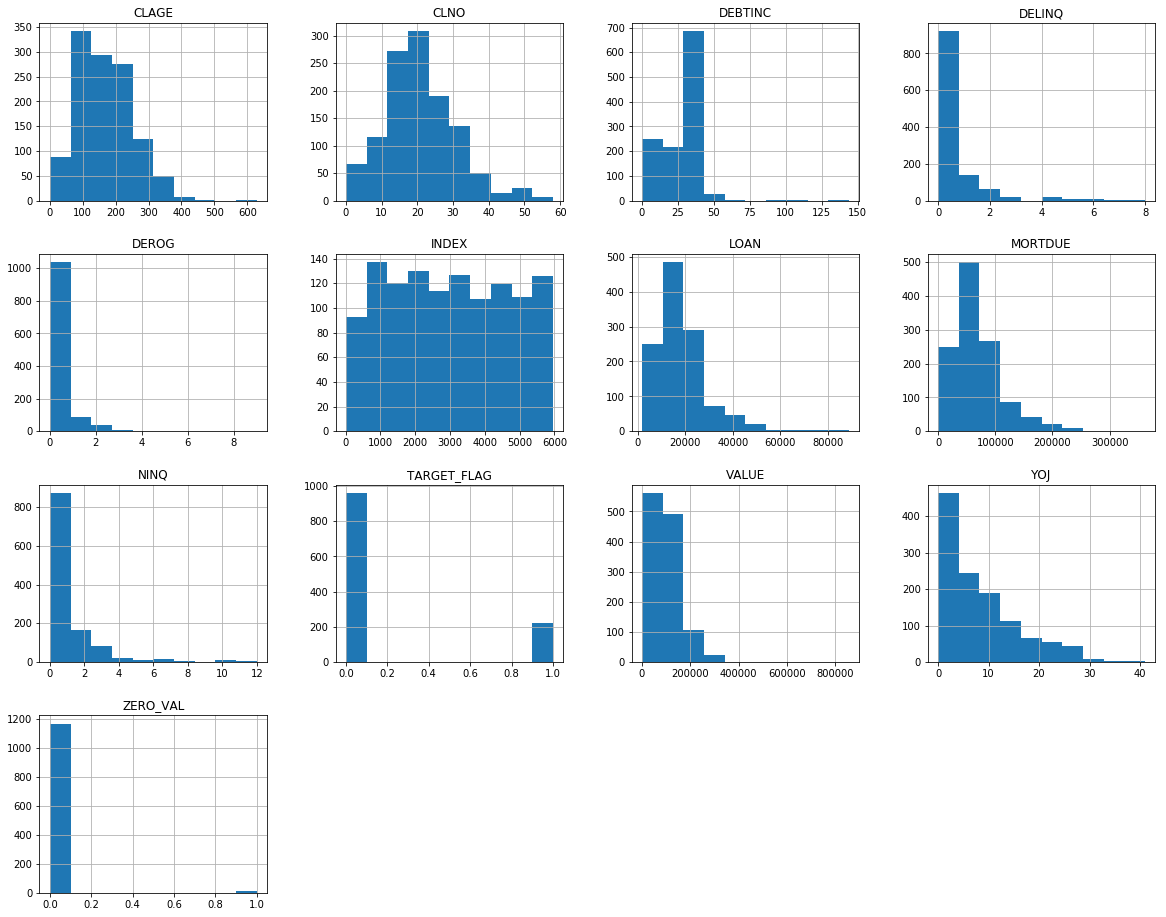

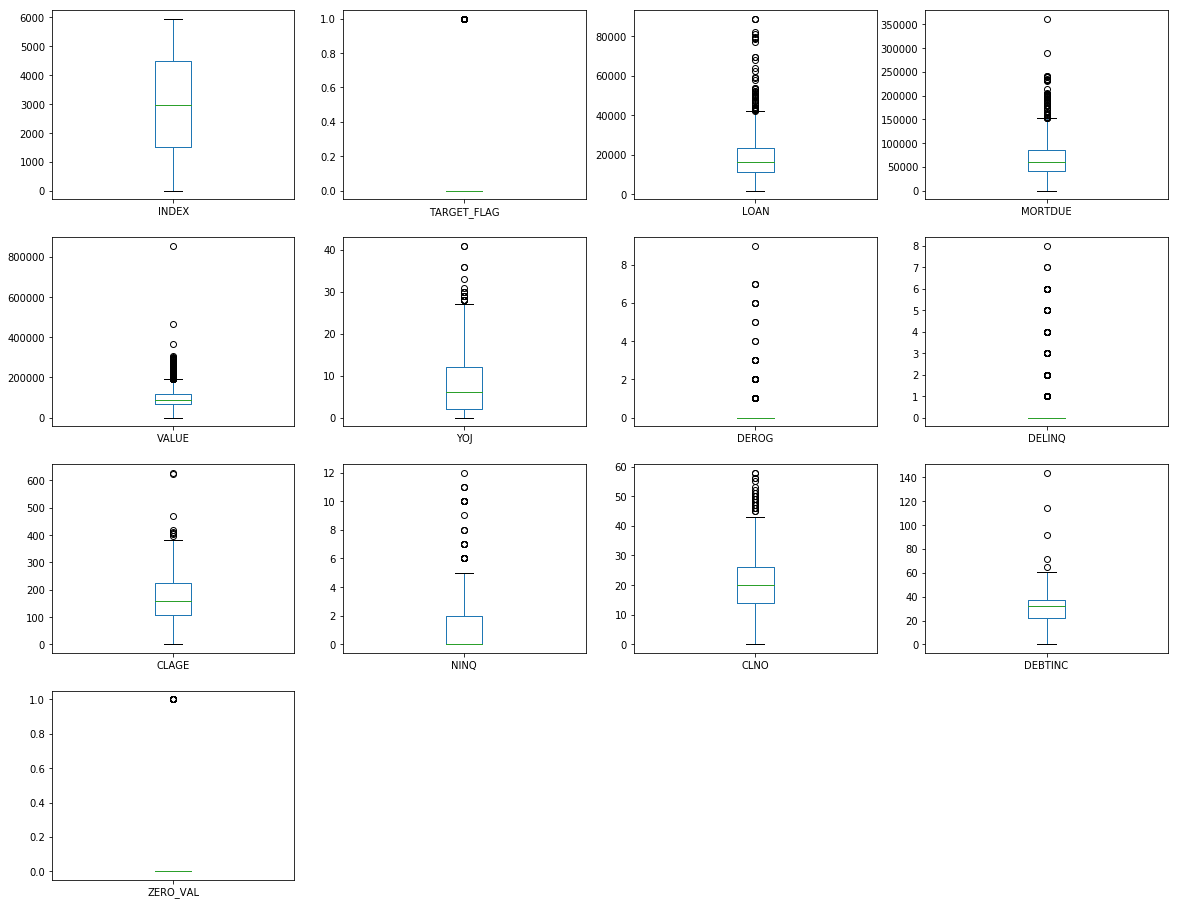

In [14]:
# Show test data plots
test.hist(figsize = (20, 16))
test.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))

#### Additional Observations about these data
We don't have any sense of timeframes for these data. For instance, we could do some additional analysis if we had dates of past events in the customer's credit history. If we had dates of delinquencies or inquiries or derogatory remarks we might rate them differentyl than a simple count. Likewise, 
We also don't have customer account information that would indicate if they have for instance, more than one mortgage or other unique situations. Additional information about other assets would also be helpful in building an accurate prediction model. The purpose of this execerise is to implement a probability / severity model on reasonably simple data.

### Part 2 - Data Cleaning

#### Remove suspicious observations altogether
As observed in EDA, let's remove the records that have a home value of zero but a mortgage value greater than zero. Perform on both train and test.

In [15]:
# TRAIN
train = train.drop(train[train['ZERO_VAL'] > 0].index)
print('Number remaining: ' + str(len(train[train['ZERO_VAL'] > 0])))
train.describe()

Number remaining: 0


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,ZERO_VAL
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.0
mean,2965.147429,0.190571,18445.657143,67601.474594,101864.532383,8.172786,0.206286,0.378571,170.277410,1.082286,20.334571,26.801867,0.0
std,1721.528748,0.392808,11000.899493,46714.510535,58247.101117,7.662995,0.737487,1.040944,93.144326,1.689223,10.758903,15.555485,0.0
min,2.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1477.750000,0.000000,11000.000000,39219.750000,65533.750000,2.000000,0.000000,0.000000,107.169028,0.000000,14.000000,20.916835,0.0
50%,2962.500000,0.000000,16250.000000,62331.500000,89707.500000,6.000000,0.000000,0.000000,167.661245,0.000000,20.000000,31.823624,0.0
75%,4458.500000,0.000000,23200.000000,89206.500000,121424.500000,12.000000,0.000000,0.000000,225.711592,2.000000,26.000000,37.994563,0.0
max,5960.000000,1.000000,89900.000000,369874.000000,854114.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,65.000000,203.312149,0.0


In [16]:
# TEST
test = test.drop(test[test['ZERO_VAL'] > 0].index)
print('Number remaining: ' + str(len(test[test['ZERO_VAL'] > 0])))
test.describe()

Number remaining: 0


,INDEX,TARGET_FLAG,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,ZERO_VAL
count,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.00000,1169.000000,1169.000000,1169.000000,1169.000000,1169.0
mean,2991.592814,0.178785,18843.627032,67330.854269,100969.881206,8.223524,0.207870,0.43627,168.094152,1.045338,20.716852,27.168690,0.0
std,1707.295738,0.383336,11710.101855,45529.593529,57615.736366,7.659812,0.728862,1.07569,86.660460,1.654331,10.066699,15.445625,0.0
min,6.000000,0.000000,1700.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1500.000000,0.000000,11100.000000,41130.000000,66442.000000,2.000000,0.000000,0.00000,108.019142,0.000000,14.000000,22.423002,0.0
50%,2966.000000,0.000000,16300.000000,61000.000000,87975.000000,6.000000,0.000000,0.00000,160.666667,0.000000,20.000000,32.304944,0.0
75%,4493.000000,0.000000,23500.000000,85337.000000,115954.000000,12.000000,0.000000,0.00000,223.326462,2.000000,26.000000,37.447384,0.0
max,5957.000000,1.000000,89000.000000,362000.000000,855909.000000,41.000000,9.000000,8.00000,629.095766,12.000000,58.000000,143.949605,0.0


Looking at the values above, I did not see any concerning outliers that should be addressed. A more complete analysis would require additional steps here.

### Convert categorical string variables to category codes
Let's create a new numeric variable that represents the categories as number codes


In [17]:
# TRAIN
#job types
train["JOB"] = train["JOB"].astype('category')
train["JOB_CAT"] = train["JOB"].cat.codes
#reason types
train["REASON"] = train["REASON"].astype('category')
train["REASON_CAT"] = train["REASON"].cat.codes

# TEST
#job types
test["JOB"] = test["JOB"].astype('category')
test["JOB_CAT"] = test["JOB"].cat.codes
#reason types
test["REASON"] = test["REASON"].astype('category')
test["REASON_CAT"] = test["REASON"].cat.codes

In [18]:
# Create new TRAIN variables
# risky1 - new var identifying risky loans with more than 1 delinquincies OR derogatory remarks
train['RISKY1'] = np.where(np.logical_or(train['DELINQ'] > 1, train['DEROG'] > 1), 1, 0)

# risky2 - new var for customers with debt to income ratio AND mortgage debt that are higher the 75% percentile
m1 = np.percentile(train['DEBTINC'], 75)
m2 = np.percentile(train['MORTDUE'], 75)
train['RISKY2'] = np.where(np.logical_and(train['DEBTINC'] > m1, train['MORTDUE'] > m2), 1, 0)

#log_loan
train['LOG_LOAN'] = np.log(train['LOAN'])
#log_mortdue - let's replace the mortdue zero values with the mean before creating LOG_MORTDUE
modified_mortdue = np.where(train['MORTDUE'] == 0, np.mean(train['MORTDUE']), train['MORTDUE'])
train['LOG_MORTDUE'] = np.log(modified_mortdue)
#log_yoj - let's do the same to create LOG_YOJ
modified_yoj = np.where(train['YOJ'] == 0, np.mean(train['YOJ']), train['YOJ'])
train['LOG_YOJ'] = np.log(modified_yoj)

# Do the same for the TEST variables

# Create new TEST variables
test['RISKY1'] = np.where(np.logical_or(test['DELINQ'] > 1, test['DEROG'] > 1), 1, 0)

# risky2 - new var for customers with debt to income ratio AND mortgage debt that are higher the 75% percentile
m1 = np.percentile(test['DEBTINC'], 75)
m2 = np.percentile(test['MORTDUE'], 75)
test['RISKY2'] = np.where(np.logical_and(test['DEBTINC'] > m1, test['MORTDUE'] > m2), 1, 0)

#log_loan
test['LOG_LOAN'] = np.log(test['LOAN'])
#log_mortdue - let's replace the mortdue zero values with the mean before creating LOG_MORTDUE
modified_mortdue = np.where(test['MORTDUE'] == 0, np.mean(test['MORTDUE']), test['MORTDUE'])
test['LOG_MORTDUE'] = np.log(modified_mortdue)
#log_yoj - let's do the same to create LOG_YOJ
modified_yoj = np.where(test['YOJ'] == 0, np.mean(test['YOJ']), test['YOJ'])
test['LOG_YOJ'] = np.log(modified_yoj)

INDEX             AxesSubplot(0.125,0.749828;0.133621x0.130172)
TARGET_FLAG    AxesSubplot(0.285345,0.749828;0.133621x0.130172)
LOAN            AxesSubplot(0.44569,0.749828;0.133621x0.130172)
MORTDUE        AxesSubplot(0.606034,0.749828;0.133621x0.130172)
VALUE          AxesSubplot(0.766379,0.749828;0.133621x0.130172)
YOJ               AxesSubplot(0.125,0.593621;0.133621x0.130172)
DEROG          AxesSubplot(0.285345,0.593621;0.133621x0.130172)
DELINQ          AxesSubplot(0.44569,0.593621;0.133621x0.130172)
CLAGE          AxesSubplot(0.606034,0.593621;0.133621x0.130172)
NINQ           AxesSubplot(0.766379,0.593621;0.133621x0.130172)
CLNO              AxesSubplot(0.125,0.437414;0.133621x0.130172)
DEBTINC        AxesSubplot(0.285345,0.437414;0.133621x0.130172)
ZERO_VAL        AxesSubplot(0.44569,0.437414;0.133621x0.130172)
JOB_CAT        AxesSubplot(0.606034,0.437414;0.133621x0.130172)
REASON_CAT     AxesSubplot(0.766379,0.437414;0.133621x0.130172)
RISKY1            AxesSubplot(0.125,0.28

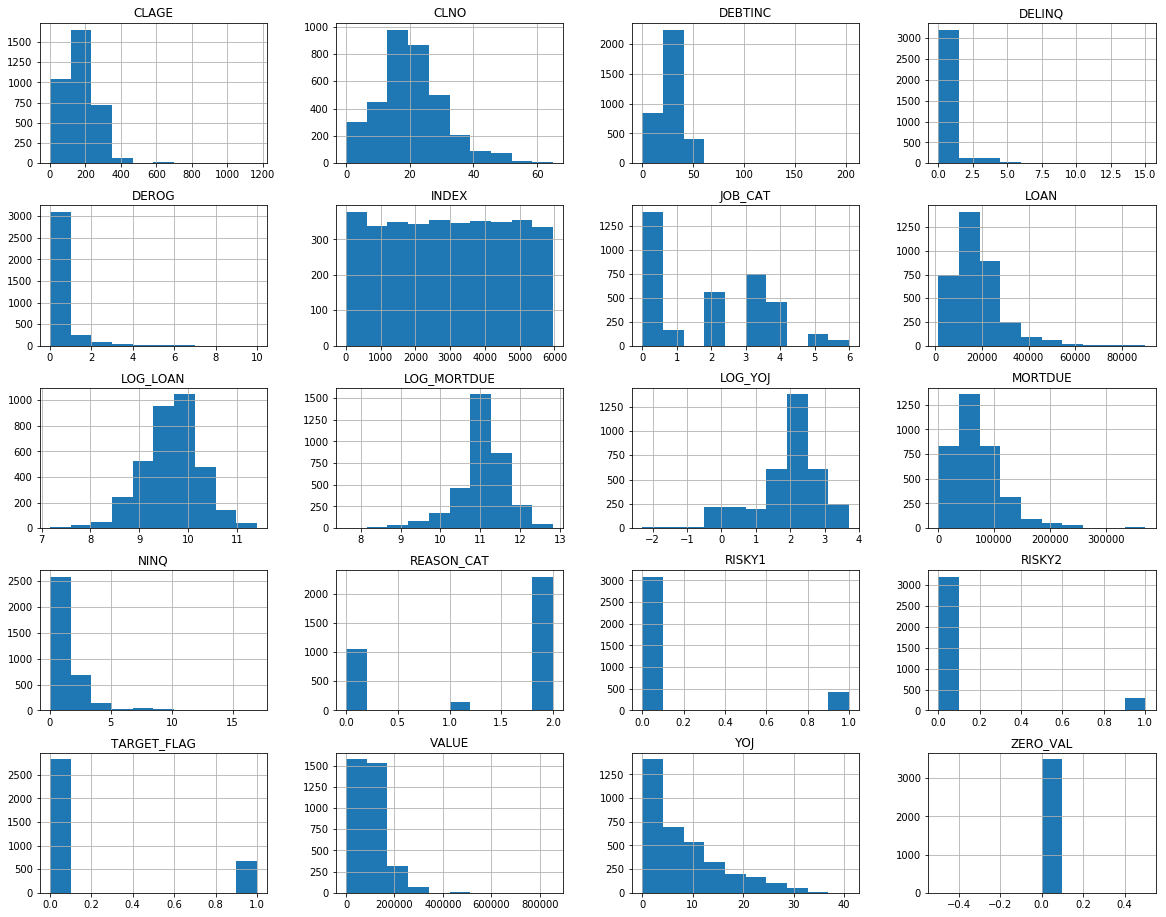

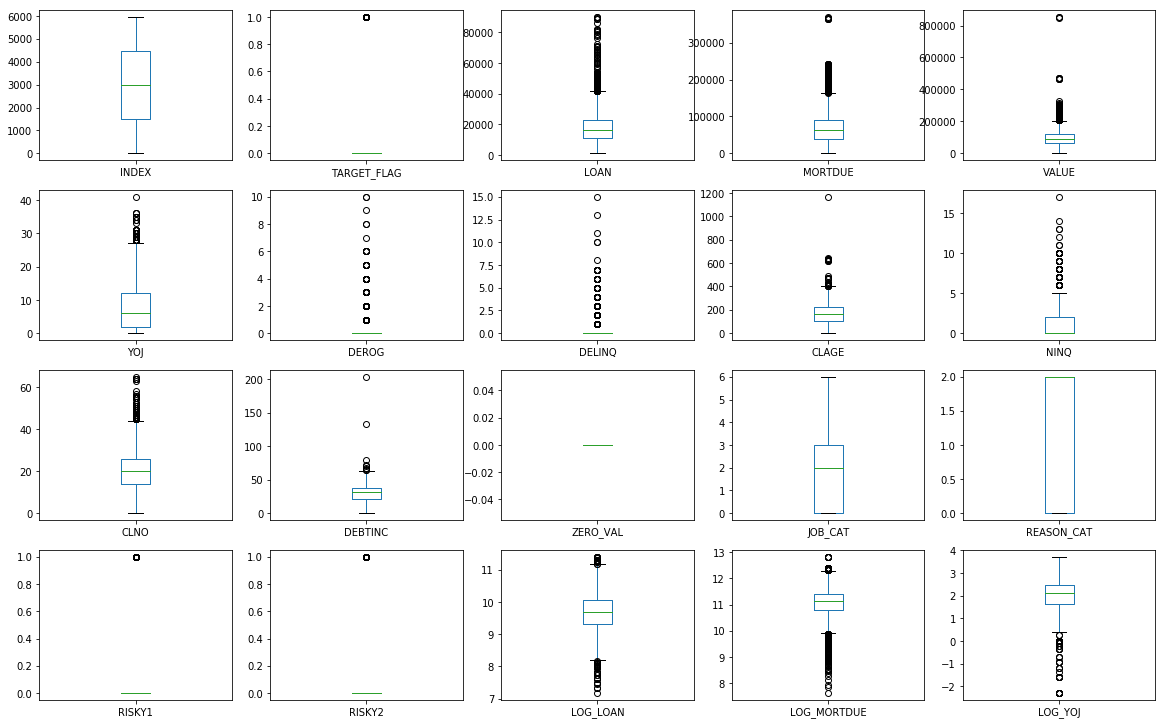

In [19]:
# Now lets replot the train and test sets with cleaned data
# ----- TRAIN ------
train.hist(figsize = (20, 16))
train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,16))

INDEX             AxesSubplot(0.125,0.749828;0.133621x0.130172)
TARGET_FLAG    AxesSubplot(0.285345,0.749828;0.133621x0.130172)
LOAN            AxesSubplot(0.44569,0.749828;0.133621x0.130172)
MORTDUE        AxesSubplot(0.606034,0.749828;0.133621x0.130172)
VALUE          AxesSubplot(0.766379,0.749828;0.133621x0.130172)
YOJ               AxesSubplot(0.125,0.593621;0.133621x0.130172)
DEROG          AxesSubplot(0.285345,0.593621;0.133621x0.130172)
DELINQ          AxesSubplot(0.44569,0.593621;0.133621x0.130172)
CLAGE          AxesSubplot(0.606034,0.593621;0.133621x0.130172)
NINQ           AxesSubplot(0.766379,0.593621;0.133621x0.130172)
CLNO              AxesSubplot(0.125,0.437414;0.133621x0.130172)
DEBTINC        AxesSubplot(0.285345,0.437414;0.133621x0.130172)
ZERO_VAL        AxesSubplot(0.44569,0.437414;0.133621x0.130172)
JOB_CAT        AxesSubplot(0.606034,0.437414;0.133621x0.130172)
REASON_CAT     AxesSubplot(0.766379,0.437414;0.133621x0.130172)
RISKY1            AxesSubplot(0.125,0.28

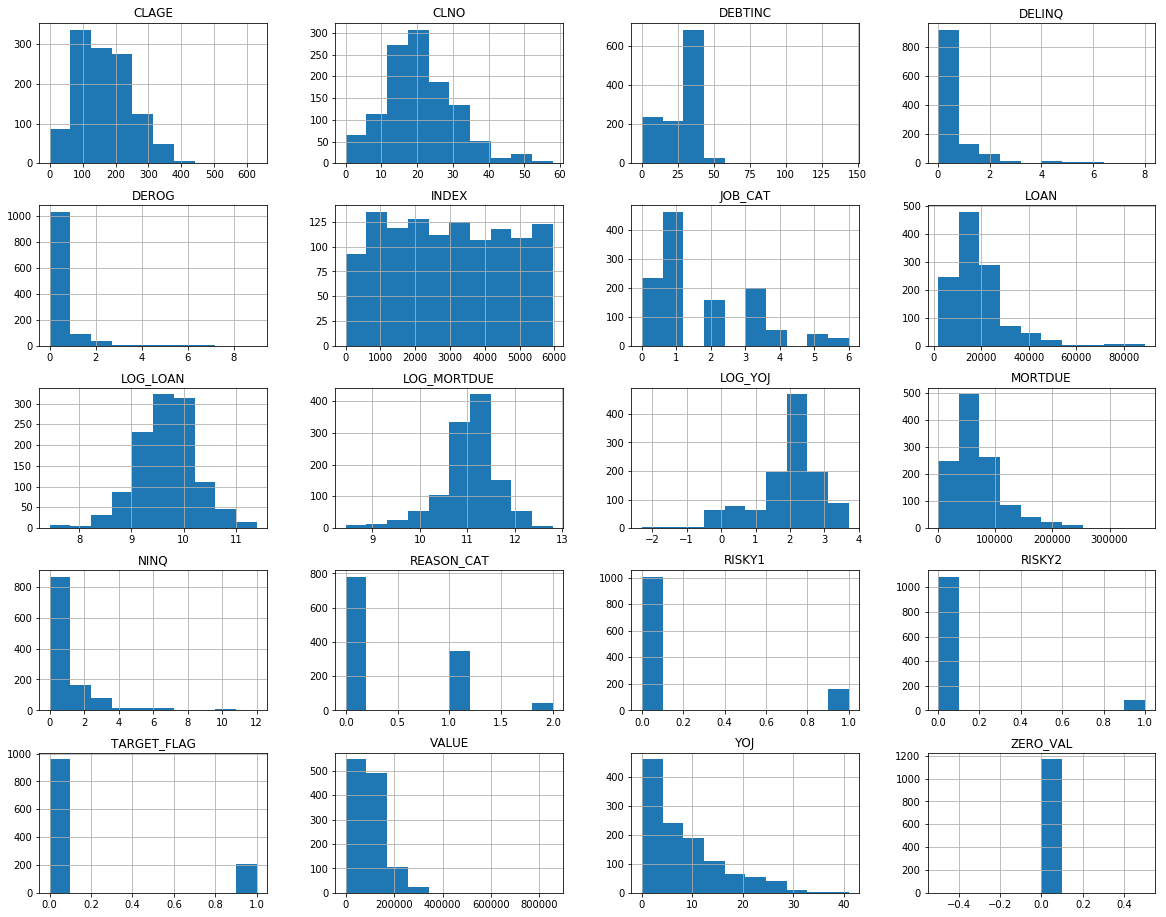

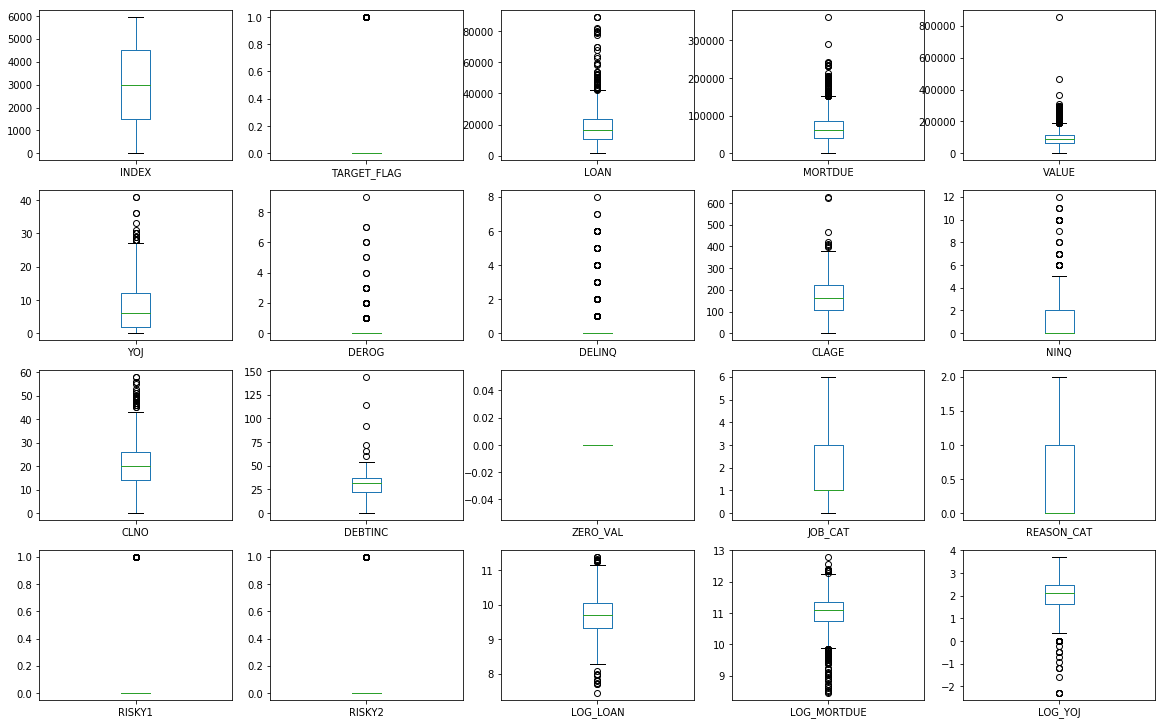

In [20]:
# ----- TEST ------
test.hist(figsize = (20, 16))
test.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,16))

We now have reasonably cleaned TRAIN and TEST data sets that we can begin building models with. 

I'll create separate data frames to use going forward. This is not entirely neccessary but helps differeniate between the two sections of the report when testing changes.

In [21]:
# TRAIN
train_clean = train

# TEST
test_clean = test

### Part 3 - Build Probability Model

I will not be performing the level of analysis done on the main assignment, but I will be evaluating three different models. The final chosen 'best' model will be selected according to the Log Likelihood and R-Squared values obtained in the logistic regression.

In [22]:
# Similar to assignment, I've defined three possible models

# model1 only considers surface-level facts about the loan and asset value. It does not include any variables associated with customer's good/bad credit history.
model1 = '''TARGET_FLAG ~  LOAN + MORTDUE + YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT'''
# model2 takes into consideration the customer's credit history in addition to variables from model 1
model2 = '''TARGET_FLAG ~  LOG_LOAN + LOG_MORTDUE + LOG_YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT + NINQ + DEROG + DELINQ + CLNO'''
# model3
model3 = '''TARGET_FLAG ~  LOG_LOAN + LOG_MORTDUE + LOG_YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT + NINQ + DEROG + DELINQ + CLNO + RISKY2'''

### Model 1

In [23]:
# Build the logit model
print('The model: ' + str(model1) + '\n')
logit1 = smf.logit(model1, data = train_clean)
result1 = logit1.fit()  
print (result1.summary())
#print (result1.conf_int())

The model: TARGET_FLAG ~  LOAN + MORTDUE + YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT

Optimization terminated successfully.
         Current function value: 0.407069
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            TARGET_FLAG   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3492
Method:                           MLE   Df Model:                            7
Date:                Sun, 05 Aug 2018   Pseudo R-squ.:                  0.1642
Time:                        21:25:34   Log-Likelihood:                -1424.7
converged:                       True   LL-Null:                       -1704.7
                                        LLR p-value:                1.060e-116
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6819

We can see a few issues with Model 1 in the summary table. First a few of our important variables are showing very high p-values (greater than 0.1) indicating that the results are not statistically significant and thus should be rejected. We will need to go back to the predictors to correct this.

One thing we can do is a log-transformation on them, which you can find in Part 2 where I created new variables for this purpose. Model 2 below shows the difference when using these log-transformed variables.

### Model 2

In [24]:
# Build the logit model 2
print('The model: ' + str(model2) + '\n')
logit2 = smf.logit(model2, data = train_clean)
result2 = logit2.fit()  
print (result2.summary())
#print (result2.conf_int())

The model: TARGET_FLAG ~  LOG_LOAN + LOG_MORTDUE + LOG_YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT + NINQ + DEROG + DELINQ + CLNO

Optimization terminated successfully.
         Current function value: 0.348141
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            TARGET_FLAG   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Sun, 05 Aug 2018   Pseudo R-squ.:                  0.2852
Time:                        21:25:38   Log-Likelihood:                -1218.5
converged:                       True   LL-Null:                       -1704.7
                                        LLR p-value:                1.697e-201
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

By performing a log-transformation on three predictors (LOAN, MORTDUE, and YOJ), I've been able to correct the problem with high p-values from Model 1 so that they are now statistically significant.

This transformation, combined with the additional variables for credit worthiness has dramatically improved my model.

### Model 3

In [25]:
# Build the logit model 3
print('The model: ' + str(model3) + '\n')
logit3 = smf.logit(model3, data = train_clean)
result3 = logit3.fit()  
print (result3.summary())
#print (result3.conf_int())

The model: TARGET_FLAG ~  LOG_LOAN + LOG_MORTDUE + LOG_YOJ + VALUE + CLAGE + DEBTINC + REASON_CAT + NINQ + DEROG + DELINQ + CLNO + RISKY2

Optimization terminated successfully.
         Current function value: 0.346878
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            TARGET_FLAG   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3487
Method:                           MLE   Df Model:                           12
Date:                Sun, 05 Aug 2018   Pseudo R-squ.:                  0.2878
Time:                        21:25:43   Log-Likelihood:                -1214.1
converged:                       True   LL-Null:                       -1704.7
                                        LLR p-value:                2.051e-202
                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

Initially I tried this Model 3 using both RISKY1 and RISKY2 however I got a p-value of 0.133 for RISKY1 and so I dropped it from the model for not be significant. 

The resulting summary using RISKY2 above gives the best overall performance of my three models.

### Final Selected Model - Model 3

My final model for scoring the predictions is **Model 3**. While a full model validation process would be completed in real world I feel this quick analysis gives the most accurate logistic model.

The Log Likelihood of -1214.1 and the R-Squared value of 0.2878 are respectively better than the other previous two models. The predicted values using this model are given in Part 4 below.

### Part 4 - Create Scored Data File

In [26]:
# Using Model 3 as selected 'best' model
# use this to predict for the cleaned test data
preds = result3.predict(test_clean)
pred_out = test_clean.loc[:,['INDEX','TARGET_FLAG']]
pred_out['P_TARGET_FLAG'] = preds[: ]

In [27]:
# Output predictions file
your_model = pred_out.loc[:,['INDEX','P_TARGET_FLAG']]
print(your_model.head())
your_model.to_csv('preds_output.csv', index = False)

       INDEX  P_TARGET_FLAG
3216  4052.0       0.262718
4058  5116.0       0.123566
2589  3254.0       0.067931
146    188.0       0.462222
3002  3783.0       0.559554


The predictions output file is named **preds_output.csv** and contains the final model predicitons for the test set. 

This file includes the INDEX and the P_TARGET_FLAG, which gives probabilities of the customer defaulting on their home equity line of credit.